# EDA King County Housing: Data Cleaning and Feature Engineering

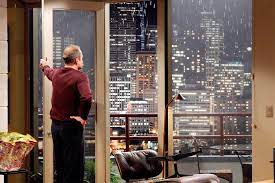

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime, date, time, timedelta


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [ ]:
# import raw data
df_kc_housing_raw = pd.read_csv('data/King_County_House_prices_dataset.csv')

# as column 'condition' is truncated in the display, disable column truncation
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', -1) 

## Data Overview

In [ ]:
# first overview of data
df_kc_housing_raw.shape


In [ ]:
df_kc_housing_raw.columns

In [ ]:
df_kc_housing_raw.head()

In [ ]:
df_kc_housing_raw.tail()

In [ ]:
df_kc_housing_raw.info()

In [ ]:
df_kc_housing_raw.describe(include='all')

## Stakeholder and Task Description

- Stakeholder wants to buy real estate for his family
- He has five children and very limited budget
- Looking to buy in a nice, social neighborhood
- Needs suggestions on timing (season, month) an location

## Cleaning and additional features

- check duplicates
- check and convert data formats in columns
- engineer new features where necessary
- check for missing values
- drop columns not used in further analyses
- save clean data set

In [ ]:
# deep copy of the df to be cleaned and processed df:
df_kc_housing = df_kc_housing_raw.copy(deep=True)

#### Duplicates

In [ ]:
# check for duplicates

df_kc_housing.duplicated().value_counts()

# the data set holds no duplicates

### Data Types

In [ ]:
# check data types for entries to clean numeric data in columns
df_kc_housing.dtypes

# date and sqft_basement need to be converted to numeric data types

In [ ]:
# check date type for first entry in column 'date' 
type(df_kc_housing['date'][0])

# convert string to timestamp format
df_kc_housing['date'] = pd.to_datetime(df_kc_housing['date'], format='%m/%d/%Y')

# check data type to control
type(df_kc_housing['date'][0])

In [ ]:
# cleaning column sqft_basement 

# first attempt to convert column entries to float
df_kc_housing = df_kc_housing.astype({'sqft_basement': float})

In [ ]:
# find '?'-character in sqft_basement column
df_kc_housing.query('sqft_basement == "?"')

#replace the `?`-character with a numpy NaN value
df_kc_housing['sqft_basement'] = df_kc_housing.sqft_basement.replace('?',np.NaN)
# change data type to float

df_kc_housing = df_kc_housing.astype({'sqft_basement': float})

df_kc_housing.sqft_basement.dtypes

### Feature Engineering 

#### Month sold

In [ ]:
# create a column with month of property selling
df_kc_housing['month_sold'] = pd.to_datetime(df_kc_housing['date']).dt.month

#### Square feet to square meter

In [ ]:
# convert square feet to square meter in column square feet living:
df_kc_housing['sqft_living'] = df_kc_housing.sqft_living.apply(lambda x: x/10.764)

df_kc_housing = df_kc_housing.astype({'sqft_living': int})

df_kc_housing = df_kc_housing.rename({'sqft_living':'sqm_living'},axis=1)


In [ ]:
# convert square feet to square meter in column square feet lot:

df_kc_housing['sqft_lot'] = df_kc_housing.sqft_lot.apply(lambda x: x/10.764)

df_kc_housing = df_kc_housing.astype({'sqft_lot': int})

df_kc_housing = df_kc_housing.rename({'sqft_lot':'sqm_lot'},axis=1)

#### Likert-Scale building condition

In [ ]:
# creating a 5-point-likert-scale of 'grade' to match the scale of 'condition' 
df_kc_housing['grade'] = df_kc_housing['grade'].map({
    3:1,
    4:1, 
    5:2,
    6:2,
    7:3,
    8:3,  
    9:3,
    10:4,
    11:4,
    12:5, 
    13:5
    })

# rename column 'grade' to 'construction'
df_kc_housing = df_kc_housing.rename({'grade':'construction'},axis=1)
# check results
df_kc_housing.construction.unique()

#### Dummy 'social neighborhood'

My stakeholder has five kids and is looking to buy in a nice, social neighborhood. 

To assess this criteria I am creating a dummy variable 'social_ngh' that holds the most family friendly districts (A-rating) in the central area of King County (Seattle and suburb Bellevue). 

Information on the most family friendly neighborhood was taken from 
https://www.niche.com/about/methodology/best-places-for-families/

The score includes public schools, rate of higher education in the population, cost of living, crime rates, family amenities, diversity, percent of household with children, percent of children below poverty, residents 17 years old an under - based on the US Census.

In [ ]:
df_kc_housing.zipcode.nunique()

In [ ]:
# bins (zip-code ranges), family friendly zip codes = 1
bins = [98001, 98003, 98010, 98013, 98015, 98106, 98112, 98116, 98125, 98141, 98144, 98194, 98195, 98198, 98199]
# dummy-labeling
labels = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

df_kc_housing['social_ngh'] = pd.cut(
    df_kc_housing.zipcode,
    bins = bins,
    labels=labels,
    ordered=False,
    include_lowest=True
)

### Missing Values

In [ ]:
# missing values
# display number of missing values per column
df_kc_housing.isna().sum()

msno.bar(df_kc_housing)
# the column 'waterfront' has approx. 10 percent of missing values, the column 'yr_renovated' approx. 20 percent. 



In [ ]:
# my stakeholder has very limited budget and it not interested in a property near the waterfront. In my case, it is best to drop the waterfront-column
# rather then to drop row-wise, as I might loose valuable information:

df_kc_housing = df_kc_housing.drop('waterfront', axis=1)

In [ ]:
# yr_renovated column hold approx. 20% of missing values, so again I would lose a lot of information if I dropped row wise. 
# My stakeholder is not explicitly interested in the year of renovation, but rather in the overall condition of the property. 
# Instead of using yr_renovated, I will use the 'condition'-scale to assess the condition of the property, 
# and am therefore dropping yr_renovated as well:

df_kc_housing = df_kc_housing.drop('yr_renovated', axis=1)


In [ ]:
# the data set does not contain missing values
df_kc_housing.isna().sum()



In [ ]:
# my client has a large family and very limited budget, he is interested in enough living space before the lot. 
# create price per square meter of living area

df_kc_housing['price_sqm_living'] = round(df_kc_housing.price/df_kc_housing.sqm_living, 0)

In [ ]:
# and create another column with price per sqm including 25% of the lot as total living area:

df_kc_housing['sqm_total'] = round(df_kc_housing.sqm_living + (df_kc_housing.sqm_lot*0.25), 0)

df_kc_housing['price_sqm_total'] = round(df_kc_housing.price/df_kc_housing.sqm_total, 0)

### Outliers

In [ ]:
# outliers
df_kc_housing.describe(include='all')
# possible outliers may be in the columns: bedrooms, bathrooms, sqm_lot

In [ ]:
# bedrooms:
df_kc_housing.bedrooms.sort_values().tail(30)

In [ ]:
df_kc_housing.iloc[15856]

In [ ]:
# 33 bedrooms with only 150 sqm of living are and 1.75 bathrooms seems implausible, likely an outlier
# delete the row
df_kc_housing.drop([15856], inplace=True)

# reset index
df_kc_housing.reset_index(inplace=True, drop=True)

In [ ]:
# check column bathrooms for outliers:
df_kc_housing.bathrooms.sort_values().tail(30)

# eight bathrooms seems plausible and do not need to ne considered outliers

In [ ]:
# check sqm_lot for outliers:
df_kc_housing.sqm_lot.sort_values().tail(30)

# such large lots are rare in the data set, but not unrealistic and do not need to be removed

### Drop not used columns

In [ ]:
#drop columns not used in further analyses, according to needs od stakeholder and analysis strategy

df_kc_clean = df_kc_housing.drop(['sqft_above','sqft_basement', 'sqm_lot', 'date', 'lat', 'long', 'view'], axis = 1)


In [ ]:
df_kc_clean

### Save clean data set

In [ ]:
# save clean df as .csv

df_kc_clean.to_csv('data/king_county_house_clean_dataset.csv', index=False)